# **`Bitcoin Price Forecasting`**
## Milestone Project 3

The goal of this notebook is to explore time series forecasting by predicting Bitcoin prices (BitPredict)


## What is a time series problem?

Time series deals with data over time:
- Predicting weather (short term and medium term forecasts), climate (long term forecasts)
- Predicting sales accross different geographies for different products in the catalog (might require a bit of geostatistics)
- Identifying special events in time, such as anomalies:
    - Anomalous weather events (maybe temperature at different pressure levels is changing), SST anomalies in the equitorial pacific ocean
    - Sensor data anomalies in an aircraft, consisting of thousands of sensors


The problems can be broadly categorized into two categories:

Problem Type       | Examples                                                                                                 | Output               
------------------ | -------------------------------------------------------------------------------------------------------- | ---------------------
**Classification** | Anomaly detection, time series identification (where did this time series come from?)                    | Discrete (a label)   
**Forecasting**    | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number)




![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)


## Contents of this Notebook


- Acquire the bitcoin time series data csv file
- Format data for time series problem
    - Split into training and test sets the wrong way
    - Split into training and test sets the right way
    - Visualizing the data
    - Converting time series forecasting into a supervised learning task
    - Preparing univariate and multivariate time series data
- Evaluate a time series forecasting model
    - Generally, this would depend on how much ahead forecast we are evaluating. 1-day error, 2-day error
    - Evaluation methods can be done for models which are trained differently. For e.g. we train a 3 window 1 horizon `model 1`, and 7 window 2 horizon `model 2`, and we want to evaluate the 2 day forecast error rate. In this case for `model 1`, we would have to forecast recursively to get the 2 day ahead. forecast
- Setting up different deep learning modelling experiments:
    - Dense models
    - Sequence models (CNN/LSTM)
    - Ensembling methods
    - Multivariate models
    - Re-implementing the N-BEATS algorithm using Tensorflow
- Creating modelling checkpoints to save the best model
- Forecasting using a time series model
- Estimation of prediction confidence intervals (quantifying forecast uncertainty)
- Discussing two types of uncertainty in machine learning
    - Data uncertainty
    - Model uncertainty
- Demonstrating why forecasting in an open system is BS (the turkey problem)





## Get the data

We have the bitcoin price data downloaded from https://www.coindesk.com/price/bitcoin:
 - Click on **all** and export data as csv

## Change project directory

In [ ]:
import os
os.chdir('/content/drive/MyDrive/projects/Tensorflow-tutorial-Daniel-Bourke/notebooks')
    

In [ ]:
import sys
sys.path.append('../')

In [ ]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3MB 7.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!nvidia-smi

Sun Jun 27 08:01:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
DATA_FILE = '../data/BTC_USD_2013-10-01_2021-06-24-CoinDesk.csv'

In [ ]:
import pandas as pd
df = pd.read_csv(DATA_FILE, parse_dates=['Date'], index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2013-10-01 to 2021-06-24
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2823 non-null   object 
 1   Closing Price (USD)  2823 non-null   float64
 2   24h Open (USD)       2823 non-null   float64
 3   24h High (USD)       2823 non-null   float64
 4   24h Low (USD)        2823 non-null   float64
dtypes: float64(4), object(1)
memory usage: 132.3+ KB


In [ ]:
# No of samples
df.shape

(2823, 5)

In [ ]:
# Date range
df.index.min(), df.index.max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2021-06-24 00:00:00'))

Let's check if any day is missing or not

In [ ]:
date_diff = pd.Series(df.index).diff()
date_diff.value_counts()

1 days    2821
2 days       1
Name: Date, dtype: int64

There is one data point where the difference is 2 days. Except for one data point, the time series is samples at daily frequency. But a time series can be samples at various frequencies as follows:

1 sample per timeframe | Number of samples per year
---------------------- | --------------------------
Second                 | 31,536,000                
Hour                   | 8,760                     
Day                    | 365                       
Week                   | 52                        
Month                  | 12                        


## Components of a time series

* **Trend**: The long term movement of the data (whether going higher or lower).
* **Seasonality** - Periodic pattern in the data (which occurs at fixed time interval) - less than a year
    * Weather obviously has a seasonal component
    * Electricity load also has a strong seasonal component, where in equitorial countries, especially in urban areas, summers will lead to peak consumption
* **Cyclicity** - Rise and fall cyclic patterns in the data (not at fixed intervals, often at longer time scales)





We will only be concerned with the closing price of Bitcoin, so will remove all other columns

In [ ]:
SELECT_COLUMN = 'Closing Price (USD)'
bitcoin_prices = df[[SELECT_COLUMN]].rename(columns={SELECT_COLUMN: 'price'})
bitcoin_prices.index.name = 'date'
bitcoin_prices.head()

,price
date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
def get_date_range(ser, format=None):
    ser = pd.to_datetime(ser, format=format)  
    ser = pd.Series(ser)
    return ser.agg(['min', 'max'])

In [ ]:
dt_range = get_date_range(bitcoin_prices.index)
dt_range

min   2013-10-01
max   2021-06-24
Name: date, dtype: datetime64[ns]

Let us plot it

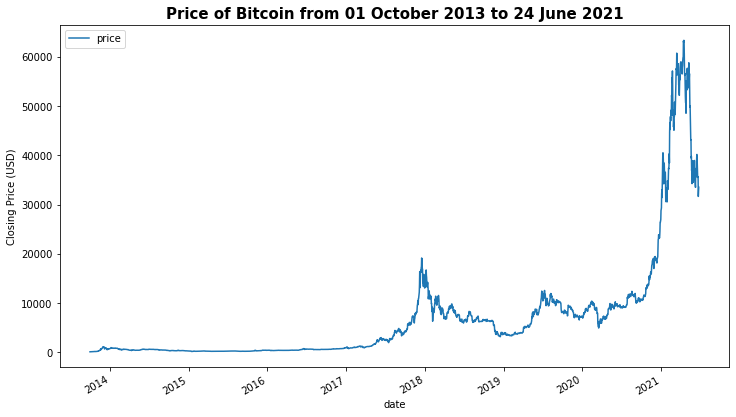

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(12, 7))
plt.ylabel(SELECT_COLUMN)
plt.title('Price of Bitcoin from {min} to {max}'.format(**dt_range.dt.strftime('%d %B %Y')),
          fontdict=dict(weight='bold', size=15));


## Importing data using the Python's `csv` module

For no apparent reason, let us try to read the data using the Python's csv module

In [ ]:
import csv

with open('../data/BTC_USD_2013-10-01_2021-06-24-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f)
    header = next(csv_reader)
    lines = []
    for line in csv_reader:
        lines.append(line)

    
pd.DataFrame(lines, columns=header).head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.455,123.65499,125.7585,123.63383
2,BTC,2013-10-03,108.58483,125.455,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.675,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


I am not so sure, why we did this all of a sudden. But okay. Moving on.

## Formatting Data - 1. Creating training and tests sets the wrong way



Let's first turn our timesteps and prices into numpy arrays

In [ ]:
timesteps, prices = bitcoin_prices.index.to_numpy(), bitcoin_prices['price'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((2258,), (565,))

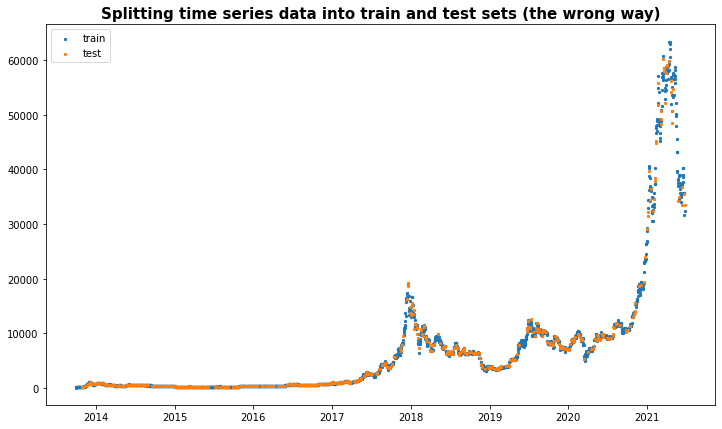

In [ ]:
plt.figure(figsize=(12, 7))
plt.scatter(X_train, y_train, s=5, label='train')
plt.scatter(X_test, y_test, s=5, label='test')
plt.legend()
plt.title('Splitting time series data into train and test sets (the wrong way)',
          fontdict=dict(size=15, weight='bold'));

The training and sets are very much overlapping. In real world, the test set for a time series data would be the data that is about to come (in the future). Hence, the above split is wrong, as some test data points are before the training data points, meaning thereby we are using the training data points to predict the past as well.

## 2. Create train and test sets the right way

The right way to create the test set is to emulate how we expect the real world test data to come i.e. the future. So we take train dataset as the past data points (80%), and the test data as the future data points (20%). 


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

In [ ]:
train_prop = 0.8
train_size = int(train_prop * len(prices))
X_train, y_train = timesteps[:train_size], prices[:train_size]
X_test, y_test = timesteps[train_size:], prices[train_size:]

len(X_train), len(X_test)

(2258, 565)

Now let us plot it

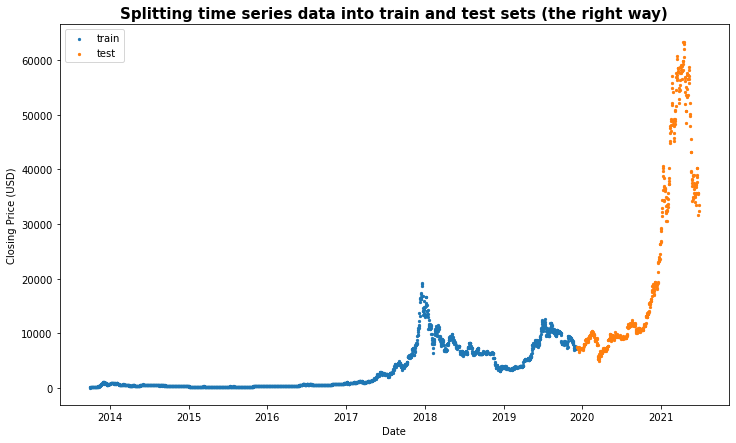

In [ ]:
plt.figure(figsize=(12, 7))
plt.scatter(X_train, y_train, label='train', s=5)
plt.scatter(X_test, y_test, label='test', s=5)
plt.xlabel('Date')
plt.ylabel(SELECT_COLUMN);
plt.legend()
plt.title('Splitting time series data into train and test sets (the right way)',
          fontdict=dict(size=15, weight='bold'));

> **Note:** The splits can vary 80/20, 90/10, 95/5 depending upon the amount of data you have. We might even have much data, in which case we can use AIC/BIC or other such model fit metrics. 
 
> **Resource:** The trickier aspects of time series modelling. See: [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387)

In [ ]:
def plot_bitcoin(tsteps, prices, linetype='.', start=0, end=None, label=None):

    plt.plot(tsteps[start:end], prices[start:end], linetype, label=label)
    plt.xlabel('Date')
    plt.ylabel(SELECT_COLUMN)
    if label:
        plt.legend(fontsize=15)

    plt.grid(True)

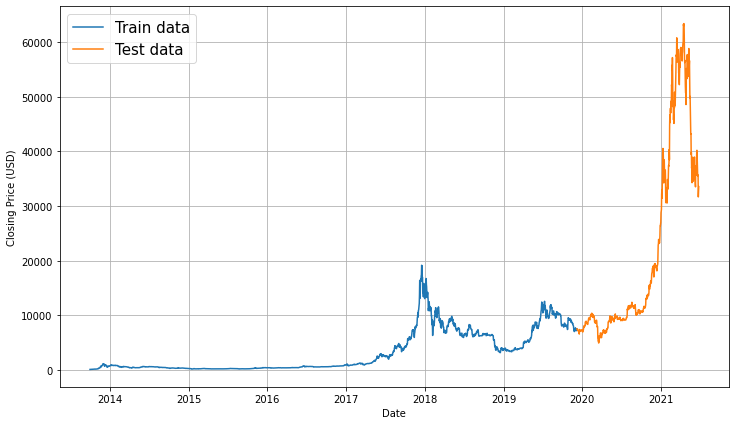

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(X_train, y_train, linetype='-', label='Train data')
plot_bitcoin(X_test, y_test, linetype='-', label='Test data')

## Modelling Experiments

Two terms are really important in the type of forecasting model we are going to build:

1. **Window** - The number of timesteps we take to predict into the future
2. **Horizon** - The number of timesteps ahead into the future we predict.

For example, a weather forecasting model with **Window** = 7, and **Horizon** = 2, uses the last 7 days weather information to predict the next two days' weather. 


Model Number | Model Type                                                       | Horizon size | Window size | Extra data       
------------ | ---------------------------------------------------------------- | ------------ | ----------- | -----------------
0            | Naïve forecast model (baseline)                                           | NA           | NA          | NA               
1            | Dense model                                                      | 1            | 7           | NA               
2            | Dense model variation                                                         | 1            | 30          | NA               
3            | Dense model variation                                                        | 7            | 30          | NA               
4            | Conv1D                                                           | 1            | 7           | NA               
5            | LSTM                                                             | 1            | 7           | NA               
6            | Dense model variation (but with multivariate data)                           | 1            | 7           | Block reward size
7            | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf)        | 1            | 7           | NA               
8            | Ensemble (multiple models optimized on different loss functions) | 1            | 7           | NA               
9            | Future prediction model (model to predict future values)         | 1            | 7           | NA               
10           | Dense Model variation (but with turkey 🦃 data introduced)                   | 1            | 7           | NA               








In [ ]:
MODELS = {}
MODELS_INFO = {}
RESULTS = {}
PREDICTIONS = {}

## Model 0: Naive Forecast (Baseline)
This is the most common baseline model for time series forecasting, which just sets the future one-day ahead forecast as the current day value. 

$$\hat{y_t} = y_{t-1}$$

> The estimate of the `t`th timestep is just equal to the value of the `t-1`th

In [ ]:
WINDOW = 1
HORIZON = 1

In [ ]:
model_name = f'naive-model-baseline_W{WINDOW}H{HORIZON}'

In [ ]:
def naive_model(y):
    return y[:-1]

naive_forecast = naive_model(y_test)
PREDICTIONS[model_name] = naive_forecast

In [ ]:
MODELS[model_name] = naive_model

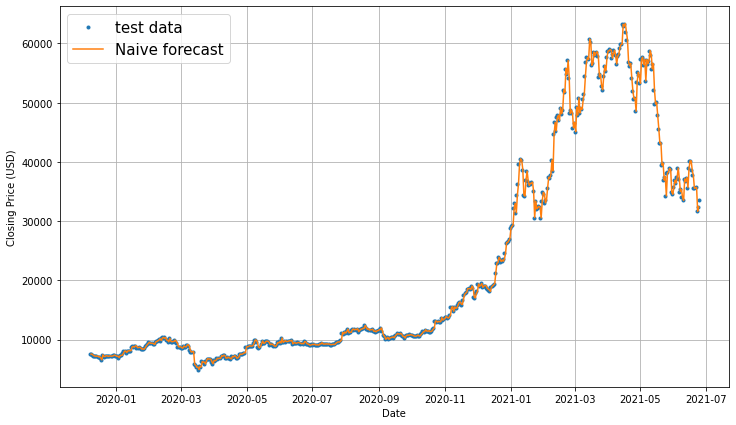

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(tsteps=X_test, prices=y_test, label='test data')
plot_bitcoin(tsteps=X_test[1:], prices=naive_forecast, linetype='-', label='Naive forecast')

## Evaluating a time series model

* Evaluation of a time series can be carried at various levels of `n_head` forecast horizons. A model trained for any horizon (= 1, say), can be used to forecast to an arbitrary future timesteps ahead by utilising its own predictions in a recursive manner.

* For the above model, we can calculate various continous value evaluation metrics such as **MAE**, **RMSE**


### Scale-dependent errors[¶](https://nbviewer.jupyter.org/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#Scale-dependent-errors)

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

Metric                            | Details                                                                                                                                                 | Code                                                                                                                                   
--------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------
**MAE** (mean absolute error)     | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError)              
**RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean.                                                                                        | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`

### Percentage errors[¶](https://nbviewer.jupyter.org/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#Percentage-errors)

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

**Metric**                                        | **Details**                                                                                                                                                                   | **Code**                                                                                                              
------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------
**MAPE** (mean absolute percentage error)         | Most commonly used percentage error. May explode (not work) if `y=0`.                                                                                                         | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE)
**sMAPE** (scaled mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp2/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation                                                                                                 

### Scaled errors[¶](https://nbviewer.jupyter.org/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#Scaled-errors)

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

**Metric**                         | **Details**                                                                                                                        | **Code**                                                                                                                                                                            
---------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
MASE (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16)

In [ ]:
import tensorflow as tf

In [ ]:
# Compared to the naive forecast, what is my MAE?
def mean_absolute_scaled_error(y_true, y_pred):
    ''' Return MASE (assuming no seasonality in the data)'''
    mae = tf.reduce_mean(tf.abs(y_true - y_pred), axis=1)

    mae_naive_no_seasonlity = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]), axis=1)

    return mae / mae_naive_no_seasonlity

* For a naive forecast the **MASE** will be 1. For a model better than the naive forecast, it should be less than 1.
    * Worse model: **MASE > 1**
    * Better model: **MASE < 1**

In [ ]:
from sklearn import metrics as skmetrics
import numpy as np

In [ ]:
def evaluate_preds(y_true, y_pred):
    # Make sure the predictions are in float32 format
    y_true = np.broadcast_to(tf.cast(y_true, dtype=tf.float32), y_pred.shape)
    y_pred = tf.cast(y_pred, dtype=tf.float32).numpy()

    # Calculate all the metrics
    mae = skmetrics.mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    mse = skmetrics.mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mape = skmetrics.mean_absolute_percentage_error(y_true, y_pred, multioutput='raw_values')
    # mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
    }

In [ ]:
RESULTS[model_name] = evaluate_preds(y_test[1:], naive_forecast)
RESULTS[model_name]

{'mae': array([645.9816], dtype=float32),
 'mape': array([0.02631178], dtype=float32),
 'mse': array([1368900.2], dtype=float32),
 'rmse': array([1170.0001], dtype=float32)}

In [ ]:
# Fine the average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

21796.140229169752

We can interpret this as follows:

* The average price in our bitcoin dataset is \$20,056 (Since there is one large peak which has its value almost 3x the average), this metric might give a skewed view of the interpretation
* Each prediction is off by \$645

Depends on how much close to the true value we want our estimate to be, this might or might not be a good model.

## Various time series models which we can use for a baseline estimation

**Model/Library Name**                                                                 | **Resource**                                                                                   
-------------------------------------------------------------------------------------- | -----------------------------------------------------------------------------------------------
Moving average                                                                         | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
ARIMA (Autoregression Integrated Moving Average)                                       | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/              
sktime (Scikit-Learn for time series)                                                  | https://github.com/alan-turing-institute/sktime                                                
TensorFlow Decision Forests (random forest, gradient boosting trees)                   | https://www.tensorflow.org/decision_forests                                                    
Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats                                                       
LinkedIn Greykite (flexible, intuitive and fast forecasts)                             | https://github.com/linkedin/greykite                                                           

## Formatting data - 2. Windowing the dataset

* Windowing is a method for turning a time series dataset into **supervised learning problem**
* For example, for a model with `window=7` and `horizon=1`, the window-horizon pair will look like:

    Data = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] \
    
    [0, 1, 2, 3, 4, 5, 6] -> [7] \
    [1, 2, 3, 4, 5, 6, 7] -> [8] \
    [2, 3, 4, 5, 6, 7, 8] -> [9] \

In [ ]:
HORIZON = 1
WINDOW = 7

In [ ]:
def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]


In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) +1, axis=0), horizon=HORIZON)
print(f'Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label.numpy())}')

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
import numpy as np

In [ ]:
def make_window_horizon_pairs(x, window, horizon):
    window_step = np.expand_dims(np.arange(window + horizon), axis=0)
    window_adders = np.expand_dims(np.arange(len(x) - (window + horizon - 1)), axis=0).T
    window_indices = window_step + window_adders

    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon)

    return windows, labels

In [ ]:
full_windows, full_labels = make_window_horizon_pairs(prices, window=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

(2816, 2816)

In [ ]:
# View first three window horizon pairs
for i in range(3):
    print(f'Window: {full_windows[i]} -> Label: {full_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


> **Note**: The function `tf.keras.preprocessing.timeseries_dataset_from_array()` does a similar job of preparing the dataset in such a format + has the added advantage of returning a `tf.data.Dataset` object which offers several benefits over traditional numpy array datasets. 

## Turning windows into training and test sets



In [ ]:
def make_train_test_splits(windows, labels, test_prop=0.2):
    split_size = int(len(windows)*(1-test_prop))
    train_windows, train_labels = windows[:split_size], labels[:split_size]
    test_windows, test_labels = windows[split_size:], labels[split_size:]

    return train_windows, train_labels, test_windows, test_labels


In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2252, 564)

So now, we have split the time series data into 80%-20% splits.

## Make a modelling checkpoint

We want to compare each model's best performance against each other. For this reason we would use `ModelCheckpoint` callback to save the best model weights during training. This would also help us resume training.

In [ ]:
import tensorflow as tf

In [ ]:
TASK = 'bitcoin_time_series_prediction'
def create_model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(f'../checkpoints/{TASK}/{model_name}', verbose=0, save_best_only=True)

In [ ]:
from src.visualize import plot_learning_curve

### Function for easy training and reloading of `KerasModel`

In [ ]:
CHECKPOINT_DIR = f'../checkpoints/bitcoin_time_series_prediction/'
HISTORY_LOG_DIR = f'../history_logs/bitcoin_time_series_prediction/'

In [ ]:
import json

def train_keras_model(training_func, model_name, 
                      model_or_checkpoint_dir=CHECKPOINT_DIR, history_log_dir=HISTORY_LOG_DIR):
    
    model_or_checkpoint_dir = os.path.join(model_or_checkpoint_dir, model_name)
    history_log_dir = os.path.join(history_log_dir, f'{model_name}.json')

    try:
        model = tf.keras.models.load_model(model_or_checkpoint_dir)
        print('loaded model successfully!')

        with open(history_log_dir, 'r') as f:
            history_dict = json.load(f)

        print('loaded history_dict successfully!')
    
    except Exception:
        history = training_func()
        history_dict = history.history
        model = history.model

        with open(history_log_dir, 'w') as f:
            json.dump(history_dict, f)


    
    return model, history_dict # Because I know the format of return value





## Model 1: Dense Model (Window = 7, Horizon = 1)

We will create a simple Dense model which takes in 7 preceding timesteps as input and predicts 1 day ahead. 

This will be the configuration of the simple dense model:

* A single dense layer with 128 neurons
* An output layer with no activation
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [ ]:
model_name = 'simple-dense_W7H1'

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(WINDOW,)),
    layers.Dense(HORIZON, activation='linear')
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "simple-dense_W7H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Training function

In [ ]:
def training_func():
     history = model.fit(train_windows, train_labels, 
                validation_data=(test_windows, test_labels), # Ideally these should have been called validation_windows, validation_labels
                epochs=100,
                batch_size=128,
                callbacks=[create_model_checkpoint(model_name=model_name)])
     
     return history

In [ ]:
model, history_dict = train_keras_model(training_func, model_name)
    
MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


Since the dataset is so small, the model trains really fast, even in CPU.

### Learning curve

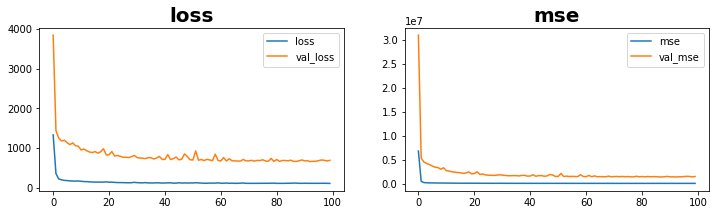

In [ ]:
plot_learning_curve(history_dict, extra_metric='mse');

### Making forecasts with a time series model 


In [ ]:
def make_preds(model, data):
    return tf.squeeze(model.predict(data))

In [ ]:
test_windows.shape

(564, 7)

In [ ]:
test_labels.shape

(564, 1)

In [ ]:
preds = make_preds(model, test_windows)
PREDICTIONS[model_name] = preds

In [ ]:
results = evaluate_preds(tf.squeeze(test_labels), preds)
RESULTS[model_name] = results
results

{'mae': array([657.3211], dtype=float32),
 'mape': array([0.02734248], dtype=float32),
 'mse': array([1407883.4], dtype=float32),
 'rmse': array([1186.5426], dtype=float32)}

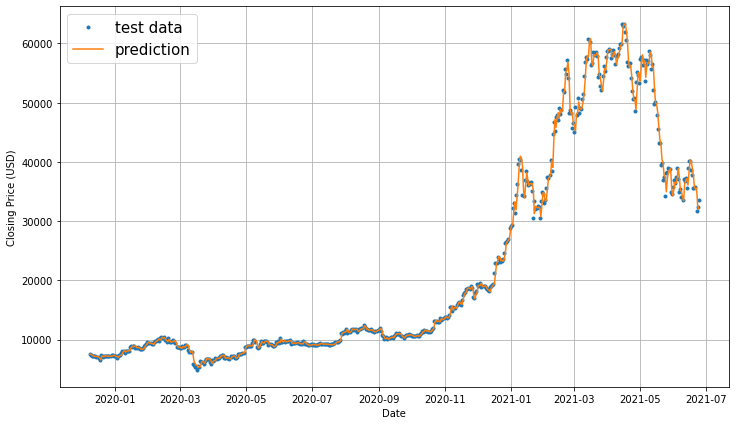

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=test_labels[:, 0], label='test data')
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=preds, linetype='-', label='prediction')

These predictions are not the actual forecasts but predictions on the test dataset for `Window = 7` and `Horizon = 1`

## Model 2: Dense (Window = 30, horizon = 1)

We will keep the previous model architecture, but make the window size = 30 i.e. we will use the past 30 timesteps to predict the next day.

In [ ]:
HORIZON = 1
WINDOW = 30

#### Make window-horizon pair dataset

In [ ]:
full_windows, full_labels = make_window_horizon_pairs(prices, window=WINDOW, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2793, 30), (2793, 1))

#### Make train test splits

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2234, 559)

In [ ]:
model_name = f'simple-dense_W{WINDOW}H{HORIZON}'

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(WINDOW,)),
    layers.Dense(HORIZON, activation='linear')
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "simple-dense_W30H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def training_func():
    history = model.fit(train_windows, train_labels,
                        validation_data=(test_windows, test_labels), 
                        epochs=100, batch_size=128,
                        callbacks=[create_model_checkpoint(model_name=model_name)])
    
    return history

In [ ]:
model, history_dict = train_keras_model(training_func, model_name)    

MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


### Learning curve

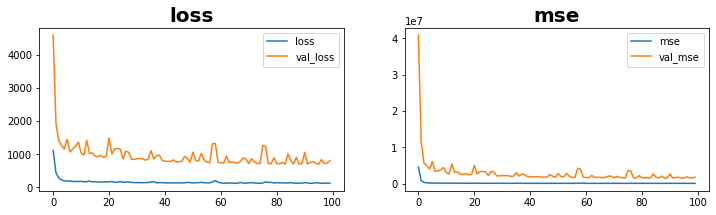

In [ ]:
plot_learning_curve(history_dict, extra_metric='mse');

### Get predictions


In [ ]:
preds = make_preds(model, test_windows)
PREDICTIONS[model_name] = preds

### Evaluate the model

In [ ]:
results = evaluate_preds(tf.squeeze(test_labels), preds)
RESULTS[model_name] = results 
results

{'mae': array([695.2544], dtype=float32),
 'mape': array([0.02886072], dtype=float32),
 'mse': array([1513971.9], dtype=float32),
 'rmse': array([1230.4357], dtype=float32)}

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f'%x)

In [ ]:
pd.DataFrame(RESULTS)

,naive-model-baseline_W1H1,simple-dense_W7H1,simple-dense_W30H1
mae,[645.9816],[657.3211],[695.2544]
mse,[1368900.2],[1407883.4],[1513971.9]
rmse,[1170.0001],[1186.5426],[1230.4357]
mape,[0.026311785],[0.027342476],[0.028860716]


The 30 window model performed worse than the 7 window model!

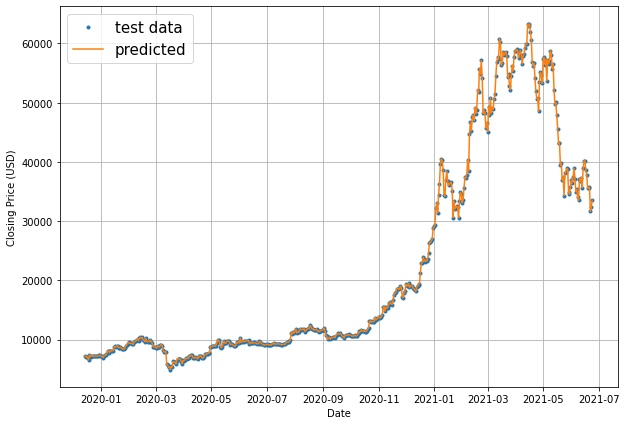

In [ ]:
plt.figure(figsize=(10, 7))
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=test_labels[:, 0], label='test data')
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=test_labels[:, 0], linetype='-', label='predicted')

## Model 3: Dense (Window = 30, horizon = 7)

Now we will predict a week ahead (horizon = 7) using all the past month data (window = 30)

#### Make window horizon pairs

In [ ]:
HORIZON = 7
WINDOW = 30

full_windows, full_labels = make_window_horizon_pairs(prices, window=WINDOW, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2787, 30), (2787, 7))

#### Make train test splits

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2229, 558)

We will again use the same architechture as model 1

In [ ]:
model_name = f'simple-dense_W{WINDOW}H{HORIZON}'

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(WINDOW,)),
    layers.Dense(HORIZON, activation='linear')
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "simple-dense_W30H7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def training_func():
    return model.fit(train_windows, train_labels, validation_data=(test_windows, test_labels),
          batch_size=128, epochs=100, verbose=0,
          callbacks=[create_model_checkpoint(model_name=model_name)])

In [ ]:
model, history_dict = train_keras_model(training_func, model_name)    

MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


#### Make predictions

In [ ]:
preds = make_preds(model, test_windows)
preds.shape

TensorShape([558, 7])

#### Evaluate the predictions

We have predictions for each time step in the horizon. Hence our error metrics will also be for 7 timesteps in the horizon.

In [ ]:
results = evaluate_preds(tf.broadcast_to(test_labels, preds.shape), preds)
RESULTS[model_name] = results
results

{'mae': array([ 765.6764,  985.5112, 1252.9808, 1483.6759, 1665.6678, 1832.3729,
        2038.6433], dtype=float32),
 'mape': array([0.03302484, 0.04054034, 0.0505597 , 0.05939244, 0.06612409,
        0.07350221, 0.08160087], dtype=float32),
 'mse': array([ 1736351.6,  3018528. ,  4652685.5,  6375201. ,  8422235. ,
        10376389. , 12933791. ], dtype=float32),
 'rmse': array([1317.7069, 1737.3911, 2157.0085, 2524.916 , 2902.1086, 3221.2402,
        3596.358 ], dtype=float32)}

#### 1-Day ahead forecast

Text(0.5, 1.0, '1-Day ahead forecast')

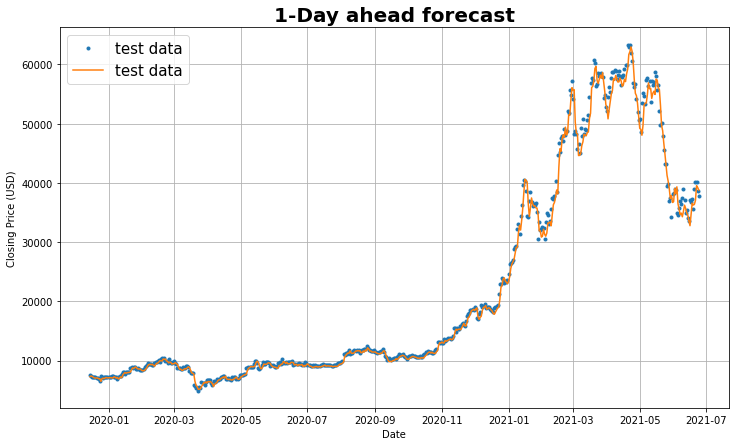

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=test_labels[:, 0], label='test data')
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=preds[:, 0], linetype='-', label='test data')
plt.title('1-Day ahead forecast', fontdict=dict(weight='bold', size=20))

#### 2-Day ahead forecast

Text(0.5, 1.0, '1-Day ahead forecast')

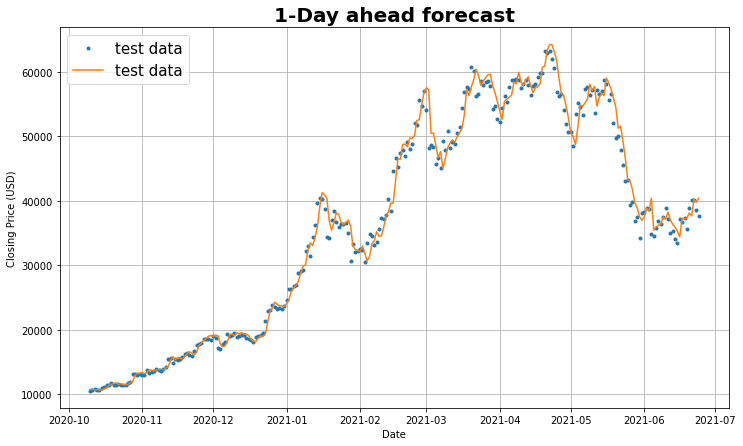

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=test_labels[:, 0], start=300, label='test data')
plot_bitcoin(tsteps=X_test[-len(test_windows):], prices=preds[:, 1], start=300, linetype='-', label='test data')
plt.title('1-Day ahead forecast', fontdict=dict(weight='bold', size=20))

## Which Dense model is performing best?

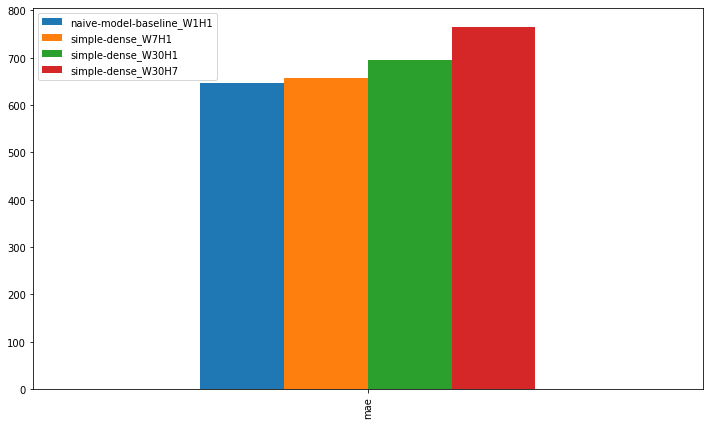

In [ ]:

def _get_day1_pred(x):
    try:
        return x[0]
    except Exception:
        return x
result_df = pd.DataFrame(RESULTS)
result_df.applymap(_get_day1_pred).loc[['mae']].plot(figsize=(12, 7), kind='bar');

* The Simple Dense model with Window = 7 and Horizon = 30 has the highest 1-day ahead `mean_absolute_error`i.e. it performs the worst out of all. 
* Still, the naive baseline model has the best i.e lowest `mean_absolute_error` rate out of all. But remember, you can't really use it to forecast ahead, as all the predictions will be set to the last timestep, which is set to its last and so on. So it will be a flat prediction.
    * One of the main reason why naive forecast performs so good is because time series data has **autocorrelation** i.e. `y_t` correlates with `y_{t-1}`

## Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW = 7

#### Make window horizon pairs

In [ ]:
full_windows, full_labels = make_window_horizon_pairs(prices, window=WINDOW, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2816, 7), (2816, 1))

#### Create train test splits

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows)

(2252, 564)

Alright, now our data is windowed as well as split into train and test sets. Are we prepared now to input the data into the CNN model? Not quite. Here is why..

The `Conv1D` layer in Tensorflow expects the input to be : `(batch_size, timesteps, num_features)`

So in our case:
* `batch_size` is 32 which we choose and is taken care of
* `timesteps` is the Window which is set to 7
* `num_features` is the number of features = 1 i.e. the time, which is there but not explicitly reflecting in the shape of the data, hence we need to expand the dimension.

Let us create an `expand_dim` layer for this.

In [ ]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
print(f'Original shape: {x.shape}')
print(f'Expanded shape: {expand_dims_layer(x).shape}')

Original shape: (7,)
Expanded shape: (7, 1)


#### Create the model

In [ ]:
model_name = f'Conv1D_W{WINDOW}H{HORIZON}'

In [ ]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(WINDOW,)),
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Flatten(),
    layers.Dense(HORIZON)
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "Conv1D_W7H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 7, 1)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7, 128)            768       
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 897       
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def training_func():
    return model.fit(train_windows, train_labels, validation_data=(test_windows, test_labels),
          batch_size=128, epochs=100, callbacks=[create_model_checkpoint(model_name=model_name)])

In [ ]:
model, history_dict = train_keras_model(training_func, model_name)    

MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


### Learning Curve

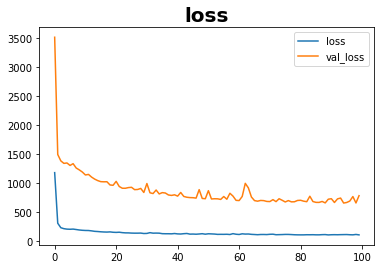

In [ ]:
plot_learning_curve(history_dict);

Highly, highly overfitted!

#### Make predictions

In [ ]:
preds = make_preds(model, test_windows)
PREDICTIONS[model_name] = preds
preds

<tf.Tensor: shape=(564,), dtype=float32, numpy=
array([ 7541.4507,  7538.419 ,  7369.965 ,  7237.2026,  7184.724 ,
        7187.412 ,  7223.9355,  7114.046 ,  7084.255 ,  6921.393 ,
        6631.929 ,  7186.379 ,  7276.2285,  7163.8823,  7198.8374,
        7248.9175,  7206.078 ,  7187.368 ,  7214.822 ,  7191.6914,
        7201.186 ,  7285.3677,  7373.8467,  7282.6475,  7175.0635,
        7152.6455,  7003.6787,  7191.7744,  7337.9785,  7364.6484,
        7612.7056,  7979.748 ,  8113.6357,  7875.896 ,  7981.4604,
        8091.0244,  8157.432 ,  8111.8335,  8574.723 ,  8873.057 ,
        8779.799 ,  8846.266 ,  8930.719 ,  8732.35  ,  8607.697 ,
        8668.239 ,  8669.643 ,  8429.824 ,  8387.077 ,  8361.985 ,
        8510.619 ,  8810.689 ,  9100.28  ,  9304.295 ,  9503.933 ,
        9445.041 ,  9359.061 ,  9356.293 ,  9298.008 ,  9188.378 ,
        9492.299 ,  9700.635 ,  9790.46  ,  9883.514 , 10085.147 ,
        9929.859 , 10114.081 , 10340.126 , 10287.595 , 10307.725 ,
       10007.1

### Evaluate predictions

In [ ]:
preds.shape

TensorShape([564])

In [ ]:
test_labels.shape

(564, 1)

In [ ]:
results = evaluate_preds(tf.squeeze(test_labels), preds)
RESULTS[model_name] = results
results

{'mae': array([658.0913], dtype=float32),
 'mape': array([0.02705742], dtype=float32),
 'mse': array([1412351.2], dtype=float32),
 'rmse': array([1188.4238], dtype=float32)}

## Did our CNN model work well?

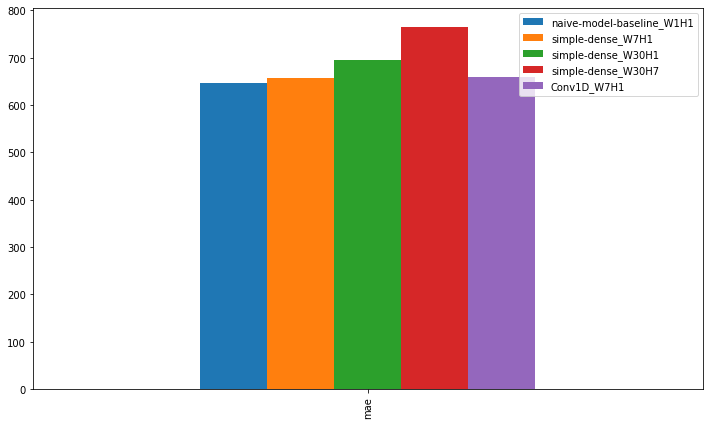

In [ ]:
result_df = pd.DataFrame(RESULTS)
result_df.applymap(_get_day1_pred).loc[['mae']].plot(figsize=(12, 7), kind='bar');

Not really an improvement :(

## Model 5: LSTM

`LSTM` layer in keras also expects the input tensor to be of the shape `[batch, timesteps, num_features]`

In [ ]:
WINDOW = 7
HORIZON = 1

In [ ]:
model_name = f'LSTM_W{WINDOW}H{HORIZON}'

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(WINDOW,)),
    expand_dims_layer,
    layers.LSTM(128, activation='relu'),
    layers.Dense(HORIZON)
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "LSTM_W7H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 7, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def training_func():
    return model.fit(train_windows, train_labels, validation_data=(test_windows, test_labels),
          batch_size=128, epochs=100, callbacks=[create_model_checkpoint(model_name)])



In [ ]:
model, history_dict = train_keras_model(training_func, model_name)    

MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


### Make predictions

In [ ]:
preds = make_preds(model, test_windows)
preds.shape

TensorShape([564])

### Evaluate predictions

In [ ]:
results = evaluate_preds(tf.squeeze(test_labels), preds)
RESULTS[model_name] = results
results

{'mae': array([763.69543], dtype=float32),
 'mape': array([0.03152551], dtype=float32),
 'mse': array([1799688.5], dtype=float32),
 'rmse': array([1341.5247], dtype=float32)}

Nope, just blindly using LSTM did not improve our result, even over the baseline naive forecast model.   

## Multivariate time series prediction

Till now all of the models could not even beat the baseline naive forecast model which just uses the previous timestep as the next timestep forecast. 

Maybe giving the model a bit more information than just the time will help explain the variation in bitcoin prices.

Almost everything, for e.g. tweets, financial news, world news could help increase the predictive power of bitcoin time series forecasting model. It is just upto us, as to how we feed this information to the model. 

Here, for now, we will include one more variable, called the Bitcoin block reward size. It is the number of bitcoins one receives from mining a Bitcoin block. 

Initially the bitcoin block reward size was 50. But every 4 years approx. the reward size is halved.

In [ ]:
bitcoin_prices.head()

,price
date,
2013-10-01,123.655
2013-10-02,125.455
2013-10-03,108.585
2013-10-04,118.675
2013-10-05,121.339


Bitcoin block reward and start dates of introduction:

Block Reward | Start Date                 
------------ | ---------------------------
50           | 3 January 2009 (2009-01-03)
25           | 28 November 2012           
12.5         | 9 July 2016                
6.25         | 11 May 2020                
3.125        | TBA (expected 2024)        
1.5625       | TBA (expected 2028)        

In [ ]:
bitcoin_price_block_df = bitcoin_prices.copy()
bitcoin_price_block_df['block_reward'] = np.nan
bitcoin_price_block_df

,price,block_reward
date,,
2013-10-01,123.655,nan
2013-10-02,125.455,nan
2013-10-03,108.585,nan
2013-10-04,118.675,nan
2013-10-05,121.339,nan
...,...,...
2021-06-20,35656.305,nan
2021-06-21,35681.134,nan
2021-06-22,31659.542,nan


In [ ]:
bitcoin_price_block_df.loc['28 November 2012': '9 July 2016', 'block_reward'] = 25
bitcoin_price_block_df.loc['9 July 2016': '11 May 2020', 'block_reward'] = 12.5
bitcoin_price_block_df.loc['11 May 2020':, 'block_reward'] = 6.125

In [ ]:
bitcoin_price_block_df

,price,block_reward
date,,
2013-10-01,123.655,25.000
2013-10-02,125.455,25.000
2013-10-03,108.585,25.000
2013-10-04,118.675,25.000
2013-10-05,121.339,25.000
...,...,...
2021-06-20,35656.305,6.125
2021-06-21,35681.134,6.125
2021-06-22,31659.542,6.125


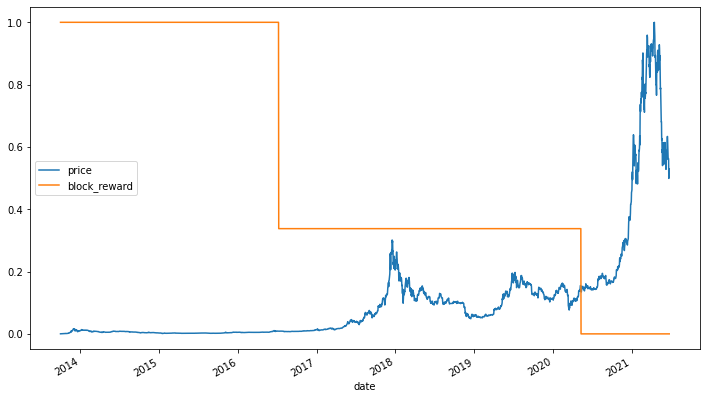

In [ ]:
from sklearn.preprocessing import minmax_scale
bitcoin_price_block_scaled_df = pd.DataFrame(minmax_scale(bitcoin_price_block_df),
                                             columns=bitcoin_price_block_df.columns,
                                             index=bitcoin_price_block_df.index)
bitcoin_price_block_scaled_df.plot(figsize=(12, 7))

### Make a windowed dataset for multivariate data

In [ ]:
HORIZON = 1
WINDOW = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_price_block_df.copy()

for i in range(WINDOW):
    bitcoin_prices_windowed[f'price_lag{i+1}'] = bitcoin_prices_windowed['price'].shift(periods=i+1)

bitcoin_prices_windowed.head()

,price,block_reward,price_lag1,price_lag2,price_lag3,price_lag4,price_lag5,price_lag6,price_lag7
date,,,,,,,,,
2013-10-01,123.655,25.000,nan,nan,nan,nan,nan,nan,nan
2013-10-02,125.455,25.000,123.655,nan,nan,nan,nan,nan,nan
2013-10-03,108.585,25.000,125.455,123.655,nan,nan,nan,nan,nan
2013-10-04,118.675,25.000,108.585,125.455,123.655,nan,nan,nan,nan
2013-10-05,121.339,25.000,118.675,108.585,125.455,123.655,nan,nan,nan


In [ ]:
bitcoin_prices_windowed.columns

Index(['price', 'block_reward', 'price_lag1', 'price_lag2', 'price_lag3',
       'price_lag4', 'price_lag5', 'price_lag6', 'price_lag7'],
      dtype='object')

The multivariate model we are going to train will be a Dense model which doesn't really care about the ordering of the sequence

So we can pass the features as 

    ['block_reward', 'price_lag1', 'price_lag2', 'price_lag3', 'price_lag4', 'price_lag5', 'price_lag6', 'price_lag7']

Let us make the $X$ and $y$ for the same

In [ ]:
X = bitcoin_prices_windowed.dropna().drop('price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['price'].astype(np.float32)
X.head()

,block_reward,price_lag1,price_lag2,price_lag3,price_lag4,price_lag5,price_lag6,price_lag7
date,,,,,,,,
2013-10-08,25.000,121.795,120.655,121.339,118.675,108.585,125.455,123.655
2013-10-09,25.000,123.033,121.795,120.655,121.339,118.675,108.585,125.455
2013-10-10,25.000,124.049,123.033,121.795,120.655,121.339,118.675,108.585
2013-10-11,25.000,125.961,124.049,123.033,121.795,120.655,121.339,118.675
2013-10-12,25.000,125.280,125.961,124.049,123.033,121.795,120.655,121.339


In [ ]:
X.shape

(2816, 8)

SO we have 1 + 7 features i.e. past 7 days bitcoin prices + the block_reward

In [ ]:
y.head()

date
2013-10-08   123.033
2013-10-09   124.049
2013-10-10   125.961
2013-10-11   125.280
2013-10-12   125.927
Name: price, dtype: float32

Now let us make the train, test splits

In [ ]:
train_prop = 0.8
train_size = int(len(X)*train_prop)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

len(X_train), len(X_test)

(2252, 564)

## Model 6: Dense (multivariate time series)

In [ ]:
model_name = f'multivariate-dense_W{WINDOW}H{HORIZON}'

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(HORIZON)
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "multivariate-dense_W7H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


There is a better way in which we can feed the block_reward size to the model. Since there is a definite order to past 7 days bitcoin prices it must be processed by a sequence model (or using transformer models as well which encode the position without the need to sequentially process them -> hence can process a sequence in parallel!)

For the block reward size, we can learn an embedding i.e. a numerical representation which we can then concatenate with the representation of the sequence data i.e. prices and make our architecture.

In [ ]:
def training_func():

    return model.fit(X_train, y_train, validation_data=(X_test, y_test),
                     batch_size=128, epochs=100, callbacks=[create_model_checkpoint(model_name)])
    

In [ ]:
model, history_dict = train_keras_model(training_func, model_name)

MODELS[model_name] = model

loaded model successfully!
loaded history_dict successfully!


### Learning Curve

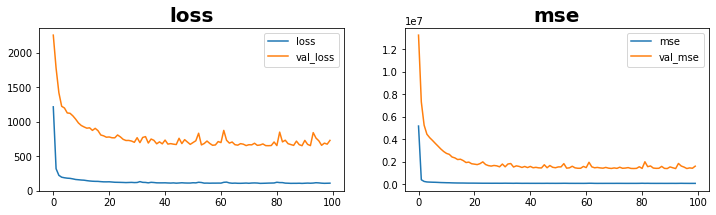

In [ ]:
plot_learning_curve(history_dict, extra_metric='mse');

### Make predictions

In [ ]:
preds = make_preds(model, X_test)
preds.shape

TensorShape([564])

### Evaluate predictions

In [ ]:
results = evaluate_preds(y_test, preds)
RESULTS[model_name] = results
results

{'mae': array([651.629], dtype=float32),
 'mape': array([0.02681939], dtype=float32),
 'mse': array([1388462.9], dtype=float32),
 'rmse': array([1178.3306], dtype=float32)}

### Comparing model performance

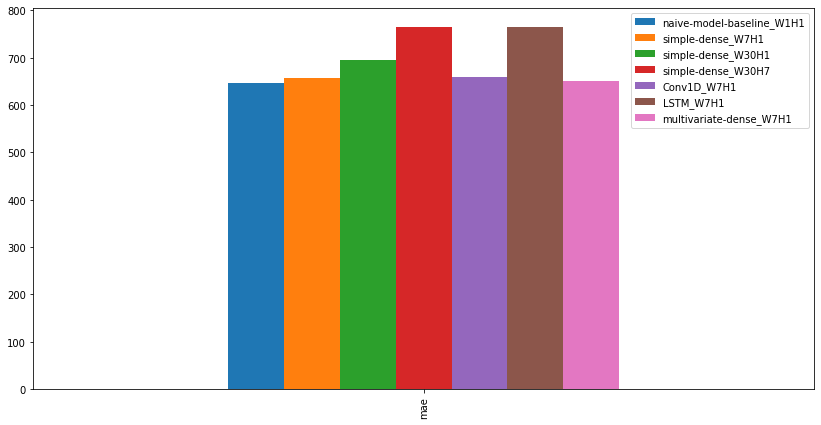

In [ ]:
result_df = pd.DataFrame(RESULTS)
result_df.applymap(_get_day1_pred).loc[['mae']].plot(figsize=(14, 7), kind='bar');

## Model 7: N-BEATS Algorithm

So far we have only tried smaller models. Now we will reimplement the architechture from the paper [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf)

The N-BEATS model was trained on a univariate time series prediction task and achieved SOTA winning performance on the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (Kaggle).

1. Replicating the model architechture 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)

2. Hyperparameters are listed in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)


To replicate the above architechture, we will:

* Create a custom layer for the `NBeatsBlock` by subclassing `tf.keras.layers.Layer`
* Implement the full architechture using the `Keras` functional API





## Building the N-BEATS block layer

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):

    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')


    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast


    def get_config(self):

        attrs = ['input_size', 'theta_size', 'horizon', 'n_neurons', 'n_layers']
        config = {attr: self.__getattribute__(attr) for attr in attrs}

        return config



In [ ]:
class NBeatsStack(tf.keras.layers.Layer):

    def __init__(self, block, n_blocks, **kwargs):
        super().__init__(**kwargs)
        self.block = block
        self.block_config = block.get_config()
        self.n_blocks = n_blocks

    def call(self, inputs):
        block_config = {**self.block_config, 'name': f'{self.name}_block0'}
        initial_block = NBeatsBlock.from_config(block_config)
        stack_residuals, stack_forecast = initial_block(inputs)

        for block_num in range(1, self.n_blocks):
            block_config = {**self.block_config, 'name': f'{self.name}_block{block_num}'}
            block = NBeatsBlock.from_config(block_config)
            block_backcast, block_forecast = block(stack_residuals)

            stack_residuals = layers.subtract([stack_residuals, block_backcast], name=f'{block.name}_subtract')
            stack_forecast = layers.add([stack_forecast, block_forecast], name=f'{block.name}_add')

        return stack_residuals, stack_forecast

In [ ]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW,
                                       theta_size=WINDOW+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_nbeats_block_layer.trainable_weights

[]

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f'Backcast: {tf.squeeze(backcast).numpy()}')
print(f'Forecast: {tf.squeeze(forecast).numpy()}')

Backcast: [ 0.19014986  0.8379836  -0.32870018  0.2515991  -0.4754027  -0.7783665
 -0.5299448 ]
Forecast: -0.7554213404655457


In [ ]:
dummy_nbeats_stack_layer = NBeatsStack(dummy_nbeats_block_layer, n_blocks=4)
dummy_nbeats_stack_layer(dummy_inputs)

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-0.49055243, -0.61159587,  0.11933358,  0.23455854, -0.0260229 ,
         -0.78948456,  0.36006966]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.22062236]], dtype=float32)>)

### Preparing data for the N-Beats algorithm using `tf.Data`

To ensure the model training runs as fast as possible, we will prepare our dataset using the `tf.Data` API.

In [ ]:
HORIZON = 1
WINDOW = 7

In [ ]:
bitcoin_prices.head()

,price
date,
2013-10-01,123.655
2013-10-02,125.455
2013-10-03,108.585
2013-10-04,118.675
2013-10-05,121.339


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW):
    bitcoin_prices_nbeats[f'price_lag{i+1}'] = bitcoin_prices_nbeats['price'].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,price,price_lag1,price_lag2,price_lag3,price_lag4,price_lag5,price_lag6,price_lag7
date,,,,,,,,
2013-10-01,123.655,nan,nan,nan,nan,nan,nan,nan
2013-10-02,125.455,123.655,nan,nan,nan,nan,nan,nan
2013-10-03,108.585,125.455,123.655,nan,nan,nan,nan,nan
2013-10-04,118.675,108.585,125.455,123.655,nan,nan,nan,nan
2013-10-05,121.339,118.675,108.585,125.455,123.655,nan,nan,nan


Make $X$ and $y$

In [ ]:
X = bitcoin_prices_nbeats.dropna().drop('price', axis=1)
y = bitcoin_prices_nbeats.dropna()['price']

In [ ]:
X.shape

(2816, 7)

Split into train and test sets

In [ ]:
train_prop = 0.8
train_size = int(len(X)*train_prop)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

len(X_train), len(X_test)

(2252, 564)

In [ ]:
X_train.shape, y_train.shape

((2252, 7), (2252,))

Now make the `tf.data.Dataset` 

In [ ]:
# Turn train features and labels into tensor Datasets
train_features_tfdata = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_tfdata = tf.data.Dataset.from_tensor_slices(y_train)

# Turn test features and labels into tensor Datasets
test_features_tfdata = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_tfdata = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels into a single dataset
train_tfdata = tf.data.Dataset.zip((train_features_tfdata, train_labels_tfdata))
test_tfdata = tf.data.Dataset.zip((test_features_tfdata, test_labels_tfdata))

# Batch and prefetch
BATCH_SIZE = 1024
train_tfdata = train_tfdata.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_tfdata = test_tfdata.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_tfdata, test_tfdata

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters and extra layers for N-BEATS algorithm

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

> **Source**: Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

In [ ]:
# Hyperparameters values different from the N-BEATS paper Figure 1 and Table 18/Appendix D

LOOKBACK = 7 # If I forecast to H-timesteps ahead, by how much factor should I lookback?
HORIZON = 1 # How much timesteps ahead I am interested to forecast?

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
N_BLOCKS = 1

INPUT_SIZE = LOOKBACK*HORIZON
THETA_SIZE = LOOKBACK + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

Now that the hyperparameters are ready, we need to create one important part of the architechture -> **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) using the `tf.keras.layers.subtract` and `tf.keras.layers.add` layers

In [ ]:
# Random features
tensor_1 = tf.range(10)
tensor_2 = tf.range(10) + 10

# Subtract
subtracted = tf.keras.layers.subtract([tensor_2, tensor_1])

# Add
added = tf.keras.layers.add([tensor_2, tensor_1])

print(f'Input tensors:\n tensor_1: {tensor_1.numpy()}\n tensor_2: {tensor_2.numpy()}\n')
print(f'Subtracted: {subtracted.numpy()}')
print(f'Added: {added.numpy()}')

Input tensors:
 tensor_1: [0 1 2 3 4 5 6 7 8 9]
 tensor_2: [10 11 12 13 14 15 16 17 18 19]

Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
model_name= f'NBeatsGeneric_W{WINDOW}H{HORIZON}'

### Creating the `NBeats` Model

Here, the number of Blocks i.e. the `NBeatsBlock` is 1 for each stack, with each such block having 4 `Block-layers`. Now this forms part of a `NBeatsStack` which are listed as being 30 in number. So as per my understanding the model architecture is as follows:

1.  The inputs are taken as `model_inputs`
2.  Now this is passed to a `NBeatsStack`.
3.  Inside the `NBeatsStack`, we have 1 `NBeatsBlock` i.e. `Block=1`
4.  Inside each `NBeatsBlock` we have 4 FC layers i.e. `Block-layers=4`, each of which outputs a block residual (subtracted cumulatively) and a block forecast (aggregated cumulatively)
5.  Finally the residual which is subtracted cumulatively is passed on to the next stack, while forecast which is aggregated cumulatively is aggregated for each stack (30 times)

In [ ]:
# Set up the stack input layer
model_inputs = layers.Input(shape=INPUT_SIZE, name='model_input')

# Set up a template block
template_block = NBeatsBlock(input_size=INPUT_SIZE, theta_size=THETA_SIZE,
                             horizon=HORIZON, n_neurons=N_NEURONS, n_layers=N_LAYERS)

# Set up the initial stack
initial_stack = NBeatsStack(template_block, n_blocks=N_BLOCKS, name='stack0')

# Get residuals and forecast from the initial stack
residuals, forecast =  initial_stack(model_inputs)

for stack_num in range(1, N_STACKS):
    stack = NBeatsStack(template_block, n_blocks=N_BLOCKS, name=f'stack{stack_num}')
    residuals, stack_forecast = stack(residuals)

    forecast = layers.add([forecast, stack_forecast], name=f'{stack.name}_add')


model = tf.keras.Model(inputs=model_inputs, outputs=forecast, name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['mse'])

model.summary()

Model: "NBeatsGeneric_W7H1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
stack0 (NBeatsStack)            ((None, 7), (None, 1 0           model_input[0][0]                
__________________________________________________________________________________________________
stack1 (NBeatsStack)            ((None, 7), (None, 1 0           stack0[0][0]                     
__________________________________________________________________________________________________
stack1_add (Add)                (None, 1)            0           stack0[0][1]                     
                                                                 stack1[0][1]    

In [ ]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name=model_name)

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [ ]:
model.summary()

Model: "NBeatsGeneric_W7H1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stack_input (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
InitialBlock (NBeatsBlock)      ((None, 7), (None, 1 796168      stack_input[0][0]                
__________________________________________________________________________________________________
NBeatsBlock_0 (NBeatsBlock)     ((None, 7), (None, 1 796168      InitialBlock[0][0]               
__________________________________________________________________________________________________
subtract_0 (Subtract)           (None, 7)            0           InitialBlock[0][0]               
                                                                 NBeatsBlock_0[0]

**Error**: Solved here: https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio. I don't know how, but this solves it.

In [ ]:

tf.config.run_functions_eagerly(True)


In [ ]:
%%time

history = model.fit(train_tfdata, epochs=N_EPOCHS, validation_data=test_tfdata, verbose=0,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])


Epoch 01020: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 01445: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 01545: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 22min 52s, sys: 16.4 s, total: 23min 8s
Wall time: 22min 59s


In [ ]:
MODELS[model_name] = model

### Learning Curve

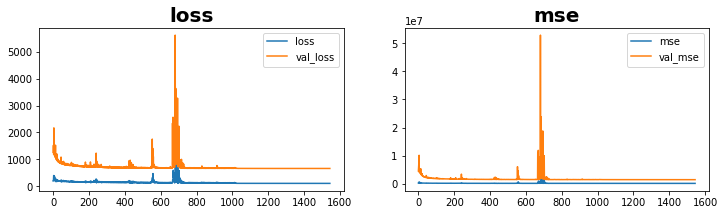

In [ ]:
plot_learning_curve(model, extra_metric='mse', include_validation=True);

Why is there a spike in the learning curve? Hmm...



Way too heavily overfitted and noisy!

### Make predictions

In [ ]:
preds = make_preds(model, test_tfdata)
preds.shape

TensorShape([564])

### Evaluate predictions

In [ ]:
results = evaluate_preds(y_test, preds)
RESULTS[model_name] = results
results

{'mae': array([657.32544], dtype=float32),
 'mape': array([0.02764818], dtype=float32),
 'mse': array([1393407.6], dtype=float32),
 'rmse': array([1180.4269], dtype=float32)}

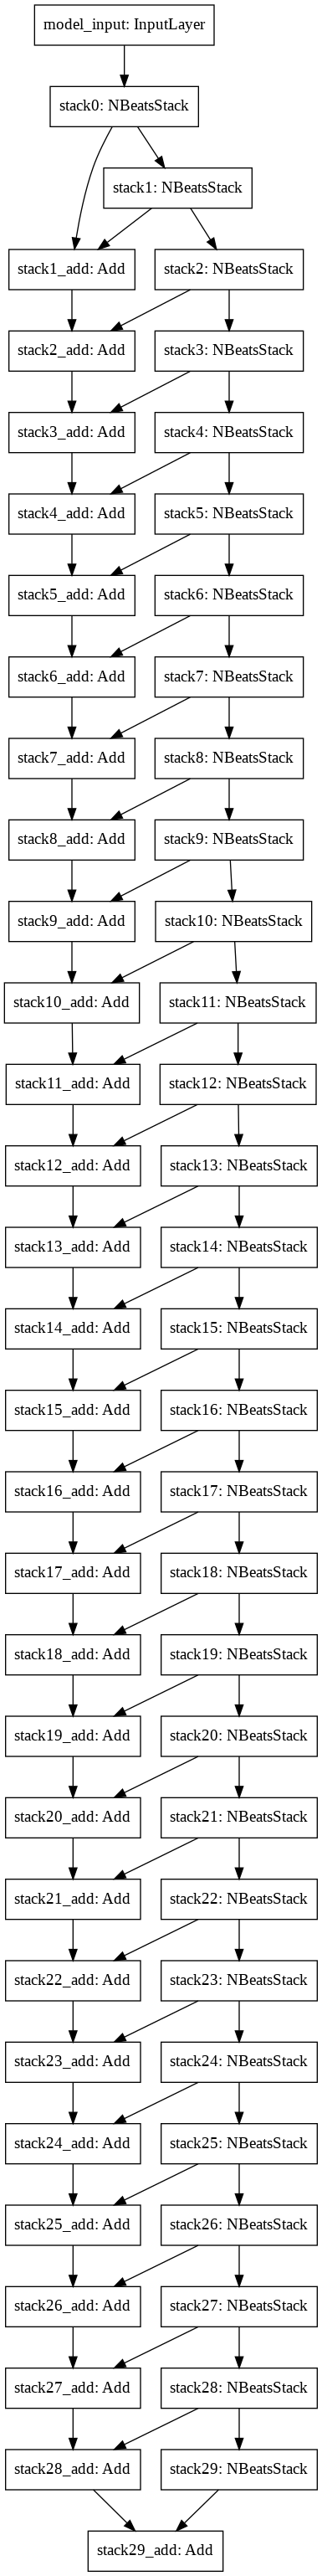

In [ ]:
from tensorflow.keras.utils import plot_model as plot_keras_model
plot_keras_model(model, to_file='/tmp/model.png')

## Model 8: Creating an ensemble (stacking different models together)

* Ensembles which are **uncorrelated** (i.e. they are somewhat different learners), when combined often yield better result. This is the "decision of the crowd effect".
* Ensembles win Kaggle competitions


In the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:

* Different loss functions (sMAPE, MASE and MAPE)
* Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)


But but but, sometimes due to the models being so big, and always being overfitted, due to the plethora of local minima present in the loss functions, even deep learning models with the same architechture with different random initilizations to their weights can produce different results
    * This is a trick used by [Chris Deotte](https://www.kaggle.com/cdeotte) by setting different random seeds


We will create our ensemble as follows:

* Using different loss functions (MAE, MSE, MAPE)
* Randomly initializing the models
    * Using a random normal distribution [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal)










In [ ]:
base_model = tf.keras.Sequential([
    layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(HORIZON)
], name='base_model')

In [ ]:
def get_ensemble_models(base_model,train_data=train_tfdata, test_data=test_tfdata,
                        n_models=10, n_epochs=100, loss_funcs=['mae', 'mse', 'mape']):
    
    ensemble_models = []
    ensemble_predictions = []
    ensemble_results = []

    y_test = list(map(lambda x: x[1], test_data)) # Get target from PrefetchDataset

    for loss in loss_funcs:

        for i in range(1, n_models+1):

            model = tf.keras.models.clone_model(base_model)
            model._name = base_model.name + f'_{loss}{i}'
            model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(),
                            metrics=['mae', 'mse'])

            print(f'Training model with loss: {loss}, variant: {i}', end='\t')

            model.fit(train_data, validation_data=test_data, epochs=n_epochs, verbose=0,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0)])
            
            preds = make_preds(model, test_data)
            results = evaluate_preds(tf.squeeze(y_test), tf.squeeze(preds))

            s = []
            for metric, val in results.items():
                s.append(f'{metric} = {float(val):.2f}')

            print(', '.join(s))

            ensemble_models.append(model)
            ensemble_predictions.append(preds)
            ensemble_results.append(results)





    return ensemble_models, ensemble_predictions, ensemble_results


In [ ]:
%%time
ensemble_models, ensemble_predictions, ensemble_results = get_ensemble_models(base_model, n_models=10, n_epochs=1000)

Training model with loss: mae, variant: 1	mae = 670.35, mse = 1435482.25, rmse = 1198.12, mape = 0.03
Training model with loss: mae, variant: 2	mae = 671.43, mse = 1465856.62, rmse = 1210.73, mape = 0.03
Training model with loss: mae, variant: 3	mae = 661.25, mse = 1445027.75, rmse = 1202.09, mape = 0.03
Training model with loss: mae, variant: 4	mae = 702.21, mse = 1536612.00, rmse = 1239.60, mape = 0.03
Training model with loss: mae, variant: 5	mae = 652.07, mse = 1424520.50, rmse = 1193.53, mape = 0.03
Training model with loss: mae, variant: 6	mae = 667.51, mse = 1452609.50, rmse = 1205.24, mape = 0.03
Training model with loss: mae, variant: 7	mae = 662.11, mse = 1429428.12, rmse = 1195.59, mape = 0.03
Training model with loss: mae, variant: 8	mae = 654.03, mse = 1364435.12, rmse = 1168.09, mape = 0.03
Training model with loss: mae, variant: 9	mae = 685.72, mse = 1528113.50, rmse = 1236.17, mape = 0.03
Training model with loss: mae, variant: 10	mae = 661.16, mse = 1421004.50, rmse = 

### Ensemble mean

In [ ]:
ensemble_mean_results = evaluate_preds(y_test, np.mean(ensemble_predictions, axis=0))
ensemble_mean_results

{'mae': array([644.93396], dtype=float32),
 'mape': array([0.02686146], dtype=float32),
 'mse': array([1369131.6], dtype=float32),
 'rmse': array([1170.099], dtype=float32)}

### Ensemble median

In [ ]:
ensemble_median_results = evaluate_preds(y_test, np.median(ensemble_predictions, axis=0))
ensemble_median_results

{'mae': array([643.4394], dtype=float32),
 'mape': array([0.02665836], dtype=float32),
 'mse': array([1370662.8], dtype=float32),
 'rmse': array([1170.753], dtype=float32)}

In [ ]:
RESULTS['ensemble-mean_W7H1'] = ensemble_mean_results
RESULTS['ensemble-median_W7H1'] = ensemble_median_results

## Plotting the prediction interval (quantifying ensemble uncertainty)

* We are assuming the distribution of the ensemble predictions to be Gaussian. This may or may not be true (likely not true).

In [ ]:
import scipy


1.959963984540054

In [ ]:
def get_confidence_interval(preds, conf=0.95):
    z_critical =  scipy.stats.norm.ppf(conf + (1-conf)/2)
    std = tf.math.reduce_std(preds, axis=0)
    interval = z_critical*std

    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return preds_mean, lower, upper

In [ ]:
preds_mean, lower, upper = get_confidence_interval(ensemble_predictions)


In [ ]:
X_test.index

DatetimeIndex(['2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15', '2019-12-16',
               '2019-12-17', '2019-12-18',
               ...
               '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18',
               '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24'],
              dtype='datetime64[ns]', name='date', length=564, freq=None)

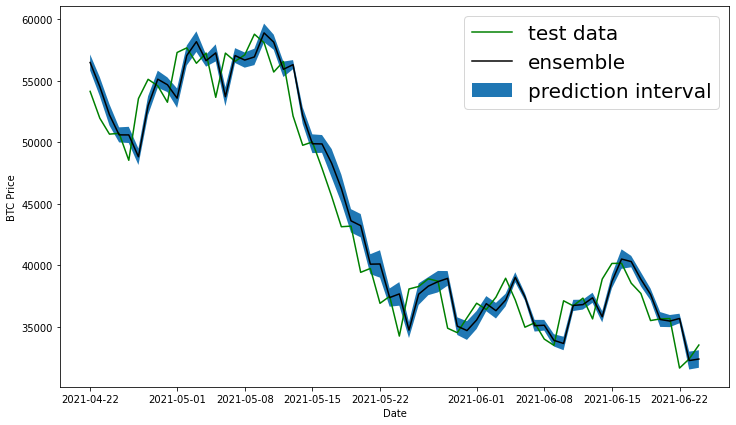

In [ ]:
plt.figure(figsize=(12, 7))
offset = 500
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='test data')
plt.plot(X_test.index[offset:], preds_mean[offset:], 'k-', label='ensemble')

plt.fill_between(X_test.index[offset:],
                 lower[offset:],
                 upper[offset:], label='prediction interval')

plt.legend(fontsize=20)

plt.xlabel('Date')
plt.ylabel('BTC Price');

Oddly, it seems like model is lagging a bit in its predictions. The Daniel Bourke notebook mentions this maybe due to overfitting, but why would overfitting cause a lag in the predictions?

## Model 9: Train a Dense model on the whole historical data to predict Bitcoin prices

After we make our artificial splits and find the best model, the final step is always to retrain the model on the whole data.

> **Note**: Forecasting models need to be trained everytime a new prediction comes (maybe through retraining or online learning to adjust the weights). But care must always be taken to not spoil the model's weights just because of one highly unusual prediction (i.e. anomaly). 

In [ ]:
bitcoin_prices_windowed.head()

,price,block_reward,price_lag1,price_lag2,price_lag3,price_lag4,price_lag5,price_lag6,price_lag7
date,,,,,,,,,
2013-10-01,123.655,25.000,nan,nan,nan,nan,nan,nan,nan
2013-10-02,125.455,25.000,123.655,nan,nan,nan,nan,nan,nan
2013-10-03,108.585,25.000,125.455,123.655,nan,nan,nan,nan,nan
2013-10-04,118.675,25.000,108.585,125.455,123.655,nan,nan,nan,nan
2013-10-05,121.339,25.000,118.675,108.585,125.455,123.655,nan,nan,nan


In [ ]:
X_all = bitcoin_prices_windowed.drop(['price', 'block_reward'], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed['price'].to_numpy()

Great we have the $X$ and the $y$ now. Now we will prepare a dataset using the `tf.data.Dataset` API

In [ ]:
# Make feature and label tfdata
features_tfdata = tf.data.Dataset.from_tensor_slices(X_all)
labels_tfdata = tf.data.Dataset.from_tensor_slices(y_all)

# Zip them together
dataset_all = tf.data.Dataset.zip((features_tfdata, labels_tfdata))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # See Appendix D of N-Beats paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
model_name = 'dense-all-data_W7H1'

In [ ]:
WINDOW = 7
HORIZON = 1

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(WINDOW,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name=model_name)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

model.summary()

Model: "dense-all-data_W7H1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291704 (Dense)         (None, 128)               1024      
_________________________________________________________________
dense_291705 (Dense)         (None, 128)               16512     
_________________________________________________________________
dense_291706 (Dense)         (None, 1)                 129       
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(dataset_all, epochs=100, verbose=0)

### Learning Curve

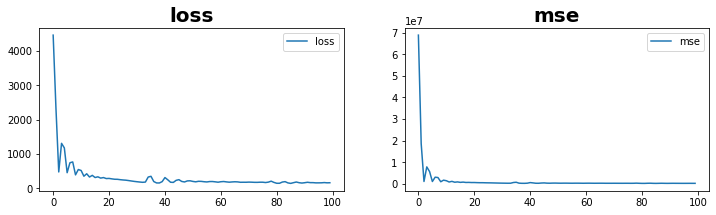

In [ ]:
plot_learning_curve(history, extra_metric='mse');

## Predicting into the future

We will predict 14 days ahead into the future with our model with `WINDOW=7`, and `HORIZON=1`

In [ ]:
N_AHEAD = 14

In [ ]:
def forecast_ahead_recursively(input_values, n_ahead, window_size, model):

    forecast = []
    last_window = input_values[-window_size:]

    for _ in range(n_ahead):
        pred = model.predict(tf.expand_dims(last_window, axis=0))
        forecast.append(tf.squeeze(pred).numpy())
        print(f'Predicting on window: {last_window} -> {tf.squeeze(pred).numpy()}\n')
        last_window = np.append(last_window, pred)[-window_size:]
    
    return forecast

In [ ]:
forecasts = forecast_ahead_recursively(y_all, n_ahead=N_AHEAD, window_size=7, model=model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Predicting on window: [37722.02018463 35520.45103404 35656.30473708 35681.13395636
 31659.54172976 32404.33035622 33532.25784581] -> 32636.619140625

Predicting on window: [35520.45103404 35656.30473708 35681.13395636 31659.54172976
 32404.33035622 33532.25784581 32636.61914062] -> 32201.40625

Predicting on window: [35656.30473708 35681.13395636 31659.54172976 32404.33035622
 33532.25784581 32636.61914062 32201.40625   ] -> 32116.45703125

Predicting on window: [35681.13395636 31659.54172976 32404.33035622 33532.25784581
 32636.61914062 32201.40625    32116.45703125] -> 32228.9921875

Predicting on window: [31659.54172976 32404.33035622 33532.25784581 32636.61914062
 32201.40625    32116.45703125 32228.9921875 ] -> 31990.830078125

Predicting on window: [32404.33035622 33532.25784581 32636.61914062 32201.40625
 32116.45703125 32228.9921875  31990.83007812] -> 31747.494140625

Predicting on window: [33532.25784581 32636.61914062 32201.40625    32116.45703125
 32228.9921875  31990.83007

## Plot future forecasts

In [ ]:
def get_future_dates(start_date, n_ahead, offset=1):
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(n_ahead, 'D')

    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [ ]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-06-24 00:00:00')

In [ ]:
forecast_timesteps = get_future_dates(start_date=last_timestep, n_ahead=N_AHEAD)
forecast_timesteps

array(['2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
       '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
       '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
       '2021-07-07', '2021-07-08'], dtype='datetime64[D]')

Incorporate the last bitcoin prize into the forecast so that the plot doesn't break in the transition

In [ ]:
forecast_timesteps = np.insert(forecast_timesteps, 0, last_timestep)
forecasts = np.insert(forecasts, 0, bitcoin_prices['price'][-1])


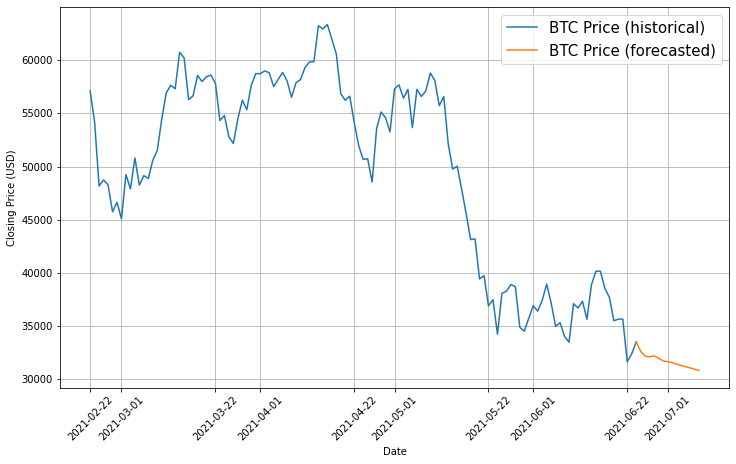

In [ ]:
plt.figure(figsize=(12, 7))
plot_bitcoin(bitcoin_prices.index, bitcoin_prices['price'], start=2700, linetype='-', label='BTC Price (historical)')
plot_bitcoin(forecast_timesteps, forecasts, linetype='-', label='BTC Price (forecasted)');
plt.xticks(rotation=45);

## Building a turkey model and why forecasting in an open system is BS



Introducing a Turkey problem to our BTC data (price BTC falls 100x in one day)


In [ ]:
btc_price_turkey = bitcoin_prices['price'].copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-06-15T00:00:00.000000000', '2021-06-16T00:00:00.000000000',
       '2021-06-17T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-06-19T00:00:00.000000000', '2021-06-20T00:00:00.000000000',
       '2021-06-21T00:00:00.000000000', '2021-06-22T00:00:00.000000000',
       '2021-06-23T00:00:00.000000000', '2021-06-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

Let's see how it looks

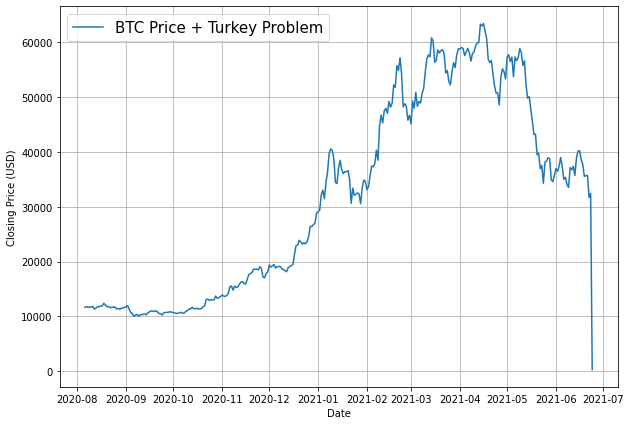

In [ ]:
plt.figure(figsize=(10, 7))
plot_bitcoin(tsteps=btc_timesteps_turkey, 
            prices=btc_price_turkey, 
            linetype="-", 
            label="BTC Price + Turkey Problem", 
            start=2500)

### Create train and test sets

In [ ]:
WINDOW = 7
HORIZON = 1

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_window_horizon_pairs(np.array(btc_price_turkey), window=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, y_train, X_test, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test)

(2252, 564)

In [ ]:
model_name = 'turkey-model_W7H1'

In [ ]:
turkey_model = tf.keras.models.clone_model(MODELS['simple-dense_W7H1'])
turkey_model._name = model_name
turkey_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])
turkey_model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[create_model_checkpoint(model_name)])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoints/bitcoin_time_series_prediction/turkey-model_W7H1/assets
INFO:tensorflow:Assets written to: ../checkpoi

### Make predictions

In [ ]:
preds = make_preds(model, X_test)
preds.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


TensorShape([564])

### Evaluate predictions

In [ ]:
results = evaluate_preds(tf.squeeze(y_test), tf.squeeze(preds))
RESULTS[model_name] = results
results

{'mae': array([780.02155], dtype=float32),
 'mape': array([0.19891468], dtype=float32),
 'mse': array([3393848.], dtype=float32),
 'rmse': array([1842.24], dtype=float32)}

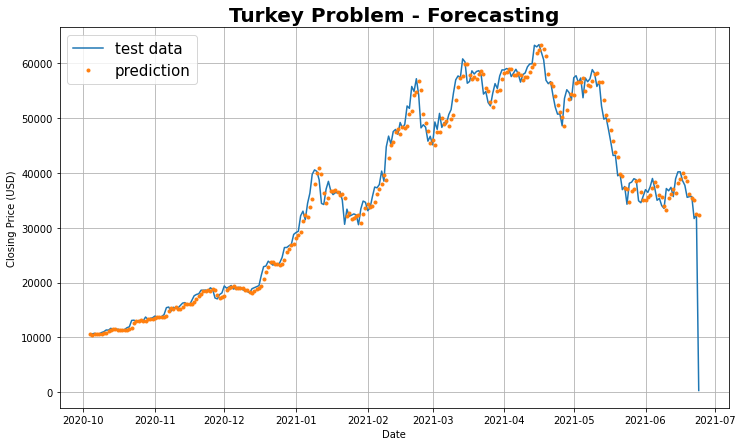

In [ ]:
plt.figure(figsize=(12, 7))
offset=300
plot_bitcoin(tsteps=btc_timesteps_turkey[-len(X_test):], 
                 prices=btc_price_turkey[-len(y_test):], 
                 linetype="-", 
                 label="test data", start=offset)
plot_bitcoin(tsteps=btc_timesteps_turkey[-len(X_test):],
                 prices=preds, 
                 label="prediction", 
                 start=offset);

plt.title('Turkey Problem - Forecasting', fontdict=dict(weight='bold', size=20));

## Beautiful image from `mrdbourke` illustrating the concept of Turkey problem | Black Swan Event

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-the-turkey-problem.png)

## Compare model predictions

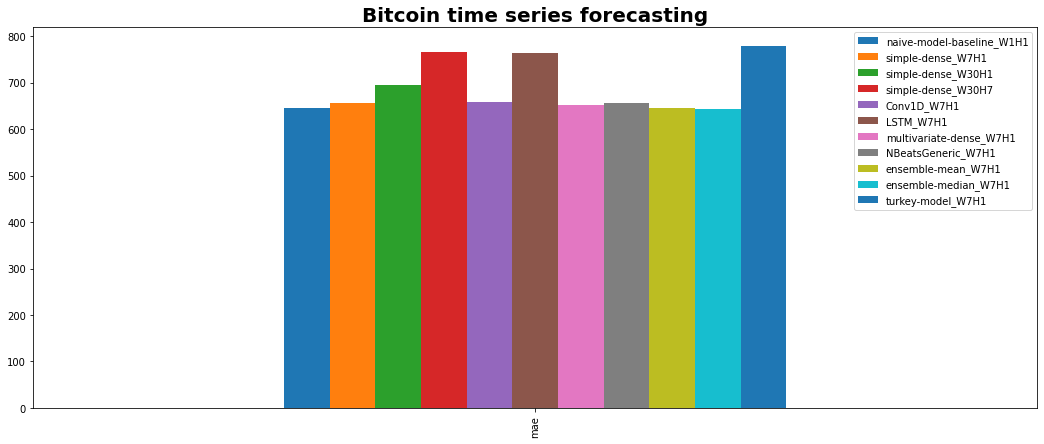

In [ ]:
result_df = pd.DataFrame(RESULTS)
result_df.applymap(_get_day1_pred).loc[['mae']].plot(figsize=(18, 7), kind='bar');
plt.title('Bitcoin time series forecasting', fontdict=dict(size=20, weight='bold'));